In [1]:
import numpy as np
import pandas as pd
import sys, os
sys.path.append("../")
from dataloaders.data_preprocessing import *
from general.utils import mkdir

%load_ext autoreload
%autoreload 2
%matplotlib inline

    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0        NaN  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                NaN    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country

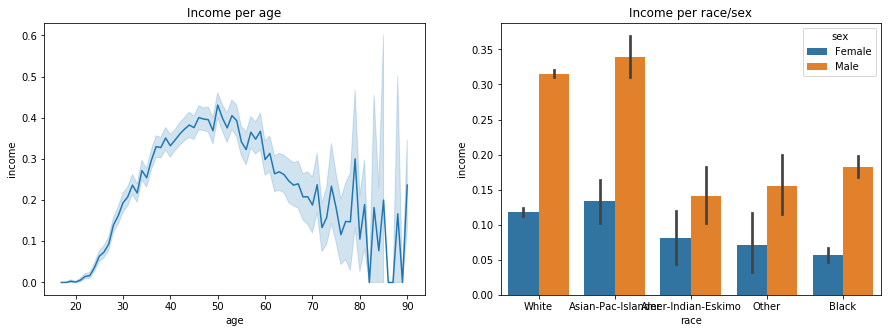

In [2]:
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True) #load adult dataset
df = data.data
df["income"] = (data.target == '>50K') * 1
print(df.head())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Income per age')
sns.lineplot(data = df,x='age',y='income')
plt.subplot(1,2,2)
plt.title('Income per race/sex')
sns.barplot(data=df,x='race',y='income', hue='sex')
plt.show()

In [4]:
## Bin ages
df['age']= np.round(df.age.values/10)*10

## change race to consider Amer-Indian-Eskimo with other,
## set race_full as old race and race_bin as white non white
df['race_full'] = np.array(df.race.values)

aux = np.array(df.race.values)
aux[aux == 'Amer-Indian-Eskimo'] = 'Other'
df['race'] = aux

aux = np.array(df.race.values)
aux[aux != 'White'] = 'nonWhite'
df['race_bin'] = aux

print('race full : ',df.race_full.unique())
print('race :',df.race.unique())
print('race bin :',df.race_bin.unique())
print()

## native country binary USA & nonUSA
aux = np.array(df['native-country'].values)
aux[aux != 'United-States'] = 'Not-United-States'
df['native-country-binary'] = aux

## index sample column
df['sample'] = np.arange(len(df))

#convert categorical columns to one-hot
s_columns = ['race_full','race','race_bin','native-country',
             'sex','income','sample']  # extract sensitive columns
df_cat, s_dic = extract_sensitive_columns(s_columns, df)
df_cat = pd.get_dummies(df_cat)

print('Categories')
for cat in df_cat.columns:
    print(cat, np.sum(df_cat[cat].values > 0))
print()
#incorporate sensitive_columns
print('Sensitive columns')
for s in s_columns:
    print(s)
    df_cat[s] = s_dic[s].values
print()

race full :  ['Black' 'White' 'Asian-Pac-Islander' 'Other']
race : ['Black' 'White' 'Asian-Pac-Islander' 'Other']
race bin : ['nonWhite' 'White']

Categories
age 48842
fnlwgt 48842
education-num 48842
capital-gain 4035
capital-loss 2282
hours-per-week 48842
workclass_Private 33906
workclass_Self-emp-not-inc 3862
workclass_Self-emp-inc 1695
workclass_Federal-gov 1432
workclass_Local-gov 3136
workclass_State-gov 1981
workclass_Without-pay 21
workclass_Never-worked 10
education_Bachelors 8025
education_Some-college 10878
education_11th 1812
education_HS-grad 15784
education_Prof-school 834
education_Assoc-acdm 1601
education_Assoc-voc 2061
education_9th 756
education_7th-8th 955
education_12th 657
education_Masters 2657
education_1st-4th 247
education_10th 1389
education_Doctorate 594
education_5th-6th 509
education_Preschool 83
marital-status_Married-civ-spouse 22379
marital-status_Divorced 6633
marital-status_Never-married 16117
marital-status_Separated 1530
marital-status_Widowed 1518


In [5]:
save_dir = '/data/MLTdata/uci_adult/dataset_processed/'
mkdir(save_dir)
df_cat.to_csv(save_dir+'bpf_dataset_cat.csv',index=0)

### Checking dataset splitting

In [8]:
from dataloaders.datasets import UCIadult_pandas

train_df,test_df,cov_tags = UCIadult_pandas(groups_list = ['sex','race_bin'],
                                            utility = 'income',norm_std = True,split=1)

 Split :  1  is loaded...
['train'] ['test']
------- UCI Adult Dataset processing ---------- 
utility :  income ; stratification_tags :  ['sex', 'race_bin', 'income'] ; standarization :  True ; len(cov_tags) :  59
ntrain :  39073  ; ntest :  9769
check: overlap train and test ?  False



../dataloaders/datasets.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_train[c] = (pd_train[c].values - mean) / std
../dataloaders/datasets.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_test[c] = (pd_test[c].values - mean) / std


In [9]:
print('train : ', len(train_df), ' samples')
print(train_df.groupby(['strat'])['utility'].count() / len(train_df))
print()
print('val : ', len(test_df), ' samples')
print(test_df.groupby(['strat'])['utility'].count() / len(test_df))
print()

train_df.head()

train :  39073  samples
strat
Female,White,0,       0.235150
Female,White,1,       0.031582
Female,nonWhite,0,    0.060144
Female,nonWhite,1,    0.004632
Male,White,0,         0.402733
Male,White,1,         0.185601
Male,nonWhite,0,      0.062678
Male,nonWhite,1,      0.017480
Name: utility, dtype: float64

val :  9769  samples
strat
Female,White,0,       0.235132
Female,White,1,       0.031528
Female,nonWhite,0,    0.060190
Female,nonWhite,1,    0.004709
Male,White,0,         0.402702
Male,White,1,         0.185587
Male,nonWhite,0,      0.062750
Male,nonWhite,1,      0.017402
Name: utility, dtype: float64



,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,...,race_bin,race_full,sex,income,sample,native-country,utility,sample_index,strat,dataset
0,-1.320198,0.351671,-1.197247,-0.144802,-0.217125,-0.034087,0.663704,-0.293016,-0.189607,-0.173793,...,nonWhite,Black,Male,0,0,United-States,0,0,"Male,nonWhite,0,",train
1,0.100466,-0.945514,-0.419331,-0.144802,-0.217125,0.772922,0.663704,-0.293016,-0.189607,-0.173793,...,White,White,Male,0,1,United-States,0,1,"Male,White,0,",train
2,-0.609866,1.394709,0.747543,-0.144802,-0.217125,-0.034087,-1.506665,-0.293016,-0.189607,-0.173793,...,White,White,Male,1,2,United-States,1,2,"Male,White,1,",train
3,0.100466,-0.277841,-0.030373,0.886865,-0.217125,-0.034087,0.663704,-0.293016,-0.189607,-0.173793,...,nonWhite,Black,Male,1,3,United-States,1,3,"Male,nonWhite,1,",train
5,-0.609866,0.085497,-1.586204,-0.144802,-0.217125,-0.841095,0.663704,-0.293016,-0.189607,-0.173793,...,White,White,Male,0,5,United-States,0,5,"Male,White,0,",train
